## 推荐系统

```
推荐系统通过确定用户和商品之间的信息，给相应的用户推荐商品
```

## 推荐系统的方法
```
1. 新品推荐 【适合新用户】
2. 基于产品评价推荐 【适合新用户】
3. 基于用户协同过滤的推荐 
4. 基于物品的系统过滤推荐
5. 隐语义推荐模型 SVD
```
###  协同过滤
```
1. 基于用户的协同过滤
  通过不同用户对商品的评分构建一个以商品为列向量 用户为横向量的 特征矩阵，通过横向量的特征向量的相似度计算(皮尔逊相似度)，计算用户之间的相似度，然后将一个用户购买过或者评分较高的商品推荐给其余用户
  
  缺点：商品种类较多，推荐系统计算量较大，且人的喜好会发生变化，过时数据就相当于无效数据。

2. 基于物品的协同过滤
  通过不同用户对商品的评分构建一个以商品为列向量 用户为横向量的 特征矩阵，通过列向量的特征向量的相似度计算(皮尔逊相似度)，计算商品之间的相似度，对于相似度较高的商品 A B C，那么查看用户购买过A的用户，则可以推荐给他B C商品。
   
```

### 隐语义模型
```
隐语义模型是在用户 和 商品之间 创建一组隐性特征，并建立 用户-隐性特征  商品-隐性特征 之间的关系矩阵。对于一个新用户则根据其评分求出用户和隐性特征之间的关系，进而可以求出与当前用户相似的用户，然后根据相似用户的商品购买和评价情况给当前用户推荐商品。

隐语义模型和LDA 主题模型相似，都是通过中间隐含特征建立二者之间的关系，也和包含一层隐层的神经网络相似。

隐语义的模型参数求解是无标签的聚类操作。
```
<img src="隐语义1.png">

### SVD 

```
隐语义模型是求出 用户-特征  商品-特征 的隐含矩阵，SVD通过酉矩阵的奇异分解得到U S V三个矩阵，通过用户的评分矩阵 计算出用户特征向量 或者商品的特征向量，然后通过用户相似度 或者 商品的相似度计算确定给用户的商品推荐，类似于协同过滤。

ps:下文有对SVD实例讲解
 ```

## 1. 数据读取

In [1]:
import pandas as pd
import numpy as np
import time
import sqlite3

data_home = './'
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt', 
                              sep='\t', header=None, 
                              names=['user','song','play_count'])

In [2]:
print(triplet_dataset.shape)
print(triplet_dataset.info())

(48373586, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48373586 entries, 0 to 48373585
Data columns (total 3 columns):
user          object
song          object
play_count    int64
dtypes: int64(1), object(2)
memory usage: 1.1+ GB
None


In [3]:
triplet_dataset.head(n=10)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


## 2.数据分析-统计用户播放量

In [4]:
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        user = line.split('\t')[0]
        play_count = int(line.split('\t')[2])
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
play_count_df = pd.DataFrame(output_list)
play_count_df = play_count_df.sort_values(by = 'play_count', ascending = False)

In [5]:
play_count_df.to_csv(path_or_buf='user_playcount_df.csv', index = False)

## 2.数据分析-统计歌曲播放量

In [6]:
output_dict = {}
with open(data_home+'train_triplets.txt') as f:
    for line_number, line in enumerate(f):
        song = line.split('\t')[1]
        play_count = int(line.split('\t')[2])
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count', ascending = False)

In [7]:
song_count_df.to_csv(path_or_buf='song_playcount_df.csv', index = False)

### 2.数据分析-查看歌曲的排行情况

In [8]:
play_count_df = pd.read_csv(filepath_or_buffer='user_playcount_df.csv')
play_count_df.head(n =10)

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04
5,6472,4ae01afa8f2430ea0704d502bc7b57fb52164882
6,6150,b7c24f770be6b802805ac0e2106624a517643c17
7,5656,113255a012b2affeab62607563d03fbdf31b08e7
8,5620,6d625c6557df84b60d90426c0116138b617b9449
9,5602,99ac3d883681e21ea68071019dba828ce76fe94d


In [9]:
song_count_df = pd.read_csv(filepath_or_buffer='song_playcount_df.csv')
song_count_df.head(10)

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3
5,356533,SOAXGDH12A8C13F8A1
6,292642,SONYKOW12AB01849C9
7,274627,SOPUCYA12A8C13A694
8,268353,SOUFTBI12AB0183F65
9,244730,SOVDSJC12A58A7A271


### 取其中一部分数（按大小排好序的了，这些应该是比较重要的数据），作为我们的实验数据

In [10]:
total_play_count = sum(song_count_df.play_count)
print ((float(play_count_df.head(n=100000).play_count.sum())/total_play_count)*100)
play_count_subset = play_count_df.head(n=100000)

40.8807280500655


In [11]:
(float(song_count_df.head(n=30000).play_count.sum())/total_play_count)*100

78.39315366645269

In [12]:
song_count_subset = song_count_df.head(n=30000)

取10W个用户，3W首歌

In [13]:
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)

过滤掉其他用户数据

In [14]:
triplet_dataset = pd.read_csv(filepath_or_buffer=data_home+'train_triplets.txt',sep='\t', 
                              header=None, names=['user','song','play_count'])
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset) ]
del(triplet_dataset)
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

In [15]:
triplet_dataset_sub_song.to_csv(path_or_buf=data_home+'triplet_dataset_sub_song.csv', index=False)

In [16]:
triplet_dataset_sub_song.shape

(10774558, 3)

In [17]:
triplet_dataset_sub_song.head(n=10)

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7
503,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26
504,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7
505,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5
506,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1
507,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8


###  加入音乐详细信息
.db文件需要稍微处理下 转换成csv

In [18]:
conn = sqlite3.connect(data_home+'track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [19]:
track_metadata_df = pd.read_sql(con=conn, sql='select * from songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [20]:
track_metadata_df_sub.to_csv(path_or_buf=data_home+'track_metadata_df_sub.csv', index=False)

In [21]:
track_metadata_df_sub.shape

(30447, 14)

### 数据观察

In [22]:
triplet_dataset_sub_song = pd.read_csv(filepath_or_buffer=data_home+'triplet_dataset_sub_song.csv',encoding = "ISO-8859-1")
track_metadata_df_sub = pd.read_csv(filepath_or_buffer=data_home+'track_metadata_df_sub.csv',encoding = "ISO-8859-1")

In [23]:
triplet_dataset_sub_song.head()

,user,song,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


In [24]:
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


### 清洗数据集
去除掉无用的和重复的

In [25]:
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song, track_metadata_df_sub, how='left', left_on='song', right_on='song_id')
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [26]:
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

In [27]:
triplet_dataset_sub_song_merged.head(n=10)

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0
5,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,You're The One,If There Was A Way,Dwight Yoakam,1990
6,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,Crowded House,1986
7,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,S.O.S.,SOS,Jonas Brothers,2007
8,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODASIJ12A6D4F5D89,1,The Invisible Man,The Invisible Man,Michael Cretu,1985
9,d6589314c0a9bcbca4fee0c93b14bc402363afea,SODEAWL12AB0187032,8,American Idiot [feat. Green Day & The Cast Of ...,The Original Broadway Cast Recording 'American...,Green Day,0


### 最流行的歌曲

In [28]:
popular_songs = triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
popular_songs_top_20 = popular_songs.sort_values('listen_count', ascending=False).head(n=20)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = (list(popular_songs_top_20['title']))
y_pos = np.arange(len(objects))
performance = list(popular_songs_top_20['listen_count'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
 
plt.show()

<Figure size 640x480 with 1 Axes>

### 最受欢迎的releases

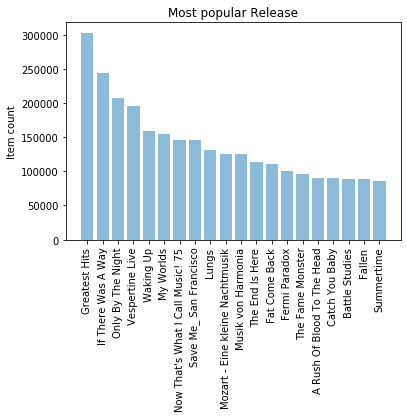

In [29]:
popular_release = triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
popular_release_top_20 = popular_release.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_release_top_20['release']))
y_pos = np.arange(len(objects))
performance = list(popular_release_top_20['listen_count'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
 
plt.show()

### 最受欢迎的歌手

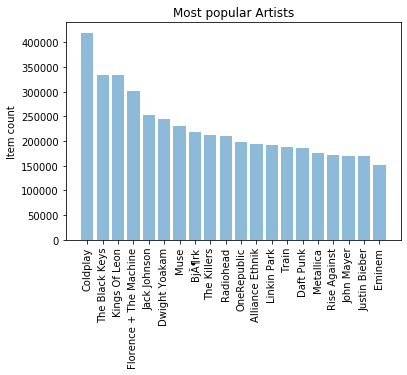

In [30]:
popular_artist = triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
popular_artist_top_20 = popular_artist.sort_values('listen_count', ascending=False).head(n=20)

objects = (list(popular_artist_top_20['artist_name']))
y_pos = np.arange(len(objects))
performance = list(popular_artist_top_20['listen_count'])
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artists')
 
plt.show()

### 用户播放量的分布

In [31]:
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(
by='title',ascending = False)
user_song_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

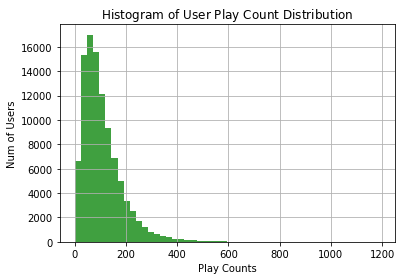

In [32]:
x = user_song_count_distribution.title
n, bins, patches = plt.hist(x, 50, facecolor='green', alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'$\mathrm{Histogram\ of\ User\ Play\ Count\ Distribution}\ $')
plt.grid(True)
plt.show()

##  3.推荐系统

In [33]:
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split

### 1.排行榜推荐

In [34]:
triplet_dataset_sub_song_merged_set = triplet_dataset_sub_song_merged
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_set, test_size = 0.40, random_state=0)

In [35]:
train_data.head()

,user,song,listen_count,title,release,artist_name,year
1901799,28866ea8a809d5d46273cd0989c5515c660ef8c7,SOEYVHS12AB0181D31,1,Monster,The Fame Monster,Lady GaGa,2009
4815185,c9608a24a2a40e0ec38993a70532e7bb56eff22b,SOKIYKQ12A8AE464FC,2,Fight For Your Life,Made In NYC,The Casualties,2000
10513026,24f0b09c133a6a0fe42f097734215dceb468d449,SOETFVO12AB018DFF3,1,Free Style (feat. Kevo_ Mussilini & Lyrical 187),A Bad Azz Mix Tape,Z-RO,0
2659073,4da3c59a0af73245cea000fd5efa30384182bfcb,SOAXJOU12A6D4F6685,1,Littlest Things,Alright_ Still,Lily Allen,2006
5506263,b46c5ed385cad7ecea8af6214f440d19de6eb6c2,SOXBCAY12AB0189EE0,1,La trama y el desenlace,Amar la trama,Jorge Drexler,2010


In [36]:
def create_popularity_recommendation(train_data, user_id, item_id):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    #Get the top 10 recommendations
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [37]:
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')
recommendations

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


### 商品协同过滤-基于歌曲相似度推荐

In [38]:
song_count_subset = song_count_df.head(n=5000)
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [39]:
triplet_dataset_sub_song_merged_sub.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [40]:
train_data, test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.30, random_state=0)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user', 'title')
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)

In [41]:
#Recommend songs for the user using personalized model
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


### 隐语义模型推荐-SVD

<img src="1.png" style="width:550px;height:280px;float:left">
<img src="5.png" style="width:350px;height:280px;float:left">


对矩阵进行SVD分解，将得到USV

<img src="2.png" style="width:500px;height:380px;float:left">
<img src="3.png" style="width:400px;height:200px;float:left">

重新计算 U*S*V的结果得到A2 来比较下A2和A的差异，看起来差异是有的，但是并不大，所以我们可以近似来代替

<img src="4.png" style="width:330px;height:220px;float:left">
<img src="5.png" style="width:330px;height:220px;float:left">

<img src="6.png" style="width:650px;height:480px;float:left">
<img src="7.png" style="width:650px;height:480px;float:left">

先计算歌曲被当前用户播放量 / 用户播放总量 当做分值

In [43]:
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329


In [44]:
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

In [45]:
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [46]:
data_sparse

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

In [47]:
user_codes[user_codes.user =='2a2f776cbac6df64d6cb505e7e834e01684673b6']

,user_index,user,us_index_value
27516,2981434,2a2f776cbac6df64d6cb505e7e834e01684673b6,27516


In [48]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [49]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [50]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)

In [ ]:
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [ ]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

In [ ]:
uTest = [27513]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [ ]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1